In [1]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
import statistics as stats
import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
import sys

## Dataset files 

In [2]:
#reviewJson = "..\\data\\Export_CleanedReview.json"
#reviewJsonWithClosedRes = "..\\data\\Export_CleanedReviewWithClosedRes.json"
#reviewJsonToronto = "..\\data\\Export_TorontoData.json"
reviewJsonToronto = "..\\data\\Cleaned_Toronto_Reviews.json"


## Load Data
Select top frenquent user and top frequenty restaurants that had at least 1 review >= 4 stars (Kickking out users that gave all  reviews <=3 and restaurants that never got start >= 4 stars)

In [3]:
def get_yelp_df(path = 'data/', filename = 'Export_CleanedReview.json', sampling=False, top_user_num=7000, top_item_num=5000):
    """
    Get the pandas dataframe
    Sampling only the top users/items by density 
    Implicit representation applies
    """
    with open(filename,'r') as f:
        data = f.readlines()
        data = list(map(json.loads, data))
    
    data = data[0]
    #Get all the data from the dggeata file
    df = pd.DataFrame(data)
    
    df.rename(columns={'stars': 'review_stars', 'text': 'review_text', 'cool': 'review_cool',
                       'funny': 'review_funny', 'useful': 'review_useful'},
              inplace=True)

    df['business_num_id'] = df.business_id.astype('category').\
        cat.rename_categories(range(0, df.business_id.nunique()))
    df['business_num_id'] = df['business_num_id'].astype('int')

    df['user_num_id'] = df.user_id.astype('category').\
    cat.rename_categories(range(0, df.user_id.nunique()))
    df['user_num_id'] = df['user_num_id'].astype('int')

    df['timestamp'] = df['date'].apply(date_to_timestamp)

    if sampling:
        df = filter_yelp_df(df, top_user_num=top_user_num, top_item_num=top_item_num)
        # Refresh num id
        df['business_num_id'] = df.business_id.astype('category').\
        cat.rename_categories(range(0, df.business_id.nunique()))
        df['business_num_id'] = df['business_num_id'].astype('int')
        
        df['user_num_id'] = df.user_id.astype('category').\
        cat.rename_categories(range(0, df.user_id.nunique()))
        df['user_num_id'] = df['user_num_id'].astype('int')
#     drop_list = ['date','review_id','review_funny','review_cool','review_useful']
#     df = df.drop(drop_list, axis=1)

    df = df.reset_index(drop = True)

    return df 

def filter_yelp_df(df, top_user_num=7000, top_item_num=5000):
    #Getting the reviews where starts are above 3
    df_implicit = df[df['review_stars']>3]
    frequent_user_id = df_implicit['user_num_id'].value_counts().head(top_user_num).index.values
    frequent_item_id = df_implicit['business_num_id'].value_counts().head(top_item_num).index.values
    return df.loc[(df['user_num_id'].isin(frequent_user_id)) & (df['business_num_id'].isin(frequent_item_id))]

def date_to_timestamp(date):
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    return time.mktime(dt.timetuple())

def df_to_sparse(df, row_name='userId', col_name='movieId', value_name='rating',
                 shape=None):
    rows = df[row_name]
    cols = df[col_name]
    if value_name is not None:
        values = df[value_name]
    else:
        values = [1]*len(rows)

    return csr_matrix((values, (rows, cols)), shape=shape)

## Get rating-UI and timestamp-UI matrix from original df

In [4]:
def get_rating_timestamp_matrix(df, sampling=False, top_user_num=7000, top_item_num=5000):
    """
    """
    #make the df implicit with top frenquent users and 
    #no need to sample anymore if df was sampled before 
    if sampling:
        df = filter_yelp_df(df, top_user_num=top_user_num, top_item_num=top_item_num)

    rating_matrix = df_to_sparse(df, row_name='user_num_id',
                                 col_name='business_num_id',
                                 value_name='review_stars',
                                 shape=None)
    
    #Have same dimension and data entries with rating_matrix, except that the review stars are - user avg
#     ratingWuserAvg_matrix = df_to_sparse(df, row_name='user_num_id',
#                                  col_name='business_num_id',
#                                  value_name='reviewStars_userAvg',
#                                  shape=None)
    
    timestamp_matrix = df_to_sparse(df, row_name='user_num_id',
                                    col_name='business_num_id',
                                    value_name='timestamp',
                                    shape=None)
    
    
    IC_matrix = get_I_C(df)
#     ratingWuserAvg_matrix
    return rating_matrix, timestamp_matrix, IC_matrix

In [5]:
def get_I_C(df):
    lst = df.categories.values.tolist()
    cat = []
    for i in range(len(lst)):
        if lst[i] is None:
            print(i)
        cat.extend(lst[i].split(', '))
        
    unique_cat = set(cat)
    #     set categories id
    df_cat = pd.DataFrame(list(unique_cat),columns=["Categories"])
    df_cat['cat_id'] = df_cat.Categories.astype('category').cat.rename_categories(range(0, df_cat.Categories.nunique()))
    dict_cat = df_cat.set_index('Categories')['cat_id'].to_dict()
    
    df_I_C = pd.DataFrame(columns=['business_num_id', 'cat_id'])
    
    for i in range((df['business_num_id'].unique().shape)[0]):
        df_temp = df[df['business_num_id'] == i].iloc[:1]
        temp_lst = df_temp['categories'].to_list()[0].split(",")
        for j in range(len(temp_lst)):
            df_I_C = df_I_C.append({'business_num_id' : i  , 'cat_id' : dict_cat[temp_lst[j].strip()]} , ignore_index=True)
    
    IC_Matrix = df_to_sparse(df_I_C, row_name='business_num_id',
                                 col_name='cat_id',
                                 value_name=None,
                                 shape=None)    
    return IC_Matrix

## Time ordered split 

In [6]:
def time_ordered_split(rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
                       implicit=True, remove_empty=False, threshold=3,
                       sampling=False, sampling_ratio=0.1):
    """
    Split the data to train,valid,test by time
    ratio:  train:valid:test
    threshold: for implicit representation
    """
    if implicit:
        temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
        temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
        rating_matrix = temp_rating_matrix
        timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
        #ratingWuserAvg_matrix = ratingWuserAvg_matrix.multiply(rating_matrix)

    nonzero_index = None

    #Default false, not removing empty columns and rows
    #Should not have this case, since users should have at least 1 record of 4,5 
    #And restuarant should have at least 1 record of 4,5 
    if remove_empty:
        # Remove empty columns. record original item index
        nonzero_index = np.unique(rating_matrix.nonzero()[1])
        rating_matrix = rating_matrix[:, nonzero_index]
        timestamp_matrix = timestamp_matrix[:, nonzero_index]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[:, nonzero_index]

        # Remove empty rows. record original user index
        nonzero_rows = np.unique(rating_matrix.nonzero()[0])
        rating_matrix = rating_matrix[nonzero_rows]
        timestamp_matrix = timestamp_matrix[nonzero_rows]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[nonzero_rows]

    user_num, item_num = rating_matrix.shape

    rtrain = []
    rtrain_userAvg = []
    rtime = []
    rvalid = []
    rvalid_userAvg = []
    rtest = []
    rtest_userAvg = []
    # Get the index list corresponding to item for train,valid,test
    item_idx_train = []
    item_idx_valid = []
    item_idx_test = []
    
    for i in tqdm(range(user_num)):
        #Get the non_zero indexs, restuarants where the user visited/liked if implicit 
        item_indexes = rating_matrix[i].nonzero()[1]
        
        #Get the data for the user
        data = rating_matrix[i].data
        
        #Get time stamp value 
        timestamp = timestamp_matrix[i].data
        
        #Get review stars with user avg data 
        if implicit == False:
            dataWuserAvg = ratingWuserAvg_matrix[i].data
        
        #Non zero reviews for this user
        num_nonzeros = len(item_indexes)
        
        #If the user has at least one review
        if num_nonzeros >= 1:
            #Get number of test and valid data 
            #train is 30%
            num_test = int(num_nonzeros * ratio[2])
            #validate is 50%
            num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))

            valid_offset = num_nonzeros - num_valid
            test_offset = num_nonzeros - num_test

            #Sort the timestamp for each review for the user
            argsort = np.argsort(timestamp)
            
            #Sort the reviews for the user according to the time stamp 
            data = data[argsort]
            
            #Sort the review with user avg accoridng to the time stamp
            if implicit == False:
                dataWuserAvg = dataWuserAvg[argsort]
            
            #Non-zero review index sort according to time
            item_indexes = item_indexes[argsort]
            
            #list of ratings, num of valid_offset index, index where there's non-zeros
            rtrain.append([data[:valid_offset], np.full(valid_offset, i), item_indexes[:valid_offset]])
            
            if implicit == False:
                #Changing valid set to binary
                count=valid_offset
                for eachData in data[valid_offset:test_offset]:
                    #if rating-avgRating > 0 then like
                    if eachData >= 4:
                        data[count] = 1
                    else:
                        data[count] = 0
                    count += 1
                
            #50%-70%
            rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                           item_indexes[valid_offset:test_offset]])
            #remaining 30%
            rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
            
            if implicit == False:
                #Now for the rating matrix that considers user average rating
                #list of ratings, num of valid_offset index, index where there's non-zeros
                rtrain_userAvg.append([dataWuserAvg[:valid_offset], np.full(valid_offset, i), item_indexes[:valid_offset]])
                #50%-70%

                #Changing valid set to binary
                count=valid_offset
                for eachData in dataWuserAvg[valid_offset:test_offset]:
                    #if rating-avgRating > 0 then like
                    if eachData > 0:
                        dataWuserAvg[count] = 1
                    else:
                        dataWuserAvg[count] = 0
                    count += 1

                rvalid_userAvg.append([dataWuserAvg[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                               item_indexes[valid_offset:test_offset]])

                #Change test set to binary even we don't use it
                countTest = test_offset
                for eachData in dataWuserAvg[test_offset:]:
                    #if rating-avgRating > 0 then like
                    if eachData > 0:
                        dataWuserAvg[count] = 1
                    else:
                        dataWuserAvg[count] = 0
                    count += 1


                #remaining 30%
                rtest_userAvg.append([dataWuserAvg[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
                
            item_idx_train.append(item_indexes[:valid_offset])
            
            item_idx_valid.append(item_indexes[valid_offset:test_offset])
            item_idx_test.append(item_indexes[test_offset:])
        else:
            item_idx_train.append([])
            item_idx_valid.append([])
            item_idx_test.append([])
    
    rtrain = np.array(rtrain)
    rvalid = np.array(rvalid)
    rtest = np.array(rtest)
    if implicit == False:
        rtrain_userAvg = np.array(rtrain_userAvg)
        rvalid_userAvg = np.array(rvalid_userAvg)
        rtest_userAvg = np.array(rtest_userAvg)

    #take non-zeros values, row index, and column (non-zero) index and store into sparse matrix
    rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
                              shape=rating_matrix.shape, dtype=np.float32)
    
    if implicit == False:
        rtrain_userAvg = sparse.csr_matrix((np.hstack(rtrain_userAvg[:, 0]), (np.hstack(rtrain_userAvg[:, 1]), np.hstack(rtrain_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rvalid_userAvg = sparse.csr_matrix((np.hstack(rvalid_userAvg[:, 0]), (np.hstack(rvalid_userAvg[:, 1]), np.hstack(rvalid_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rtest_userAvg = sparse.csr_matrix((np.hstack(rtest_userAvg[:, 0]), (np.hstack(rtest_userAvg[:, 1]), np.hstack(rtest_userAvg[:, 2]))),
                                  shape=rating_matrix.shape, dtype=np.float32)

    return rtrain, rvalid, rtest,rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, timestamp_matrix, item_idx_train, item_idx_valid, item_idx_test

In [7]:
def time_ordered_splitModified(rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
                       implicit=True, remove_empty=False, threshold=3,
                       sampling=False, sampling_ratio=0.1, trainSampling=1):
    """
    Split the data to train,valid,test by time
    ratio:  train:valid:test
    threshold: for implicit representation
    """
    
    
    if implicit:
        temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
        temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
        rating_matrix = temp_rating_matrix
        timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
        #ratingWuserAvg_matrix = ratingWuserAvg_matrix.multiply(rating_matrix)

    nonzero_index = None

    #Default false, not removing empty columns and rows
    #Should not have this case, since users should have at least 1 record of 4,5 
    #And restuarant should have at least 1 record of 4,5 
    if remove_empty:
        # Remove empty columns. record original item index
        nonzero_index = np.unique(rating_matrix.nonzero()[1])
        rating_matrix = rating_matrix[:, nonzero_index]
        timestamp_matrix = timestamp_matrix[:, nonzero_index]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[:, nonzero_index]

        # Remove empty rows. record original user index
        nonzero_rows = np.unique(rating_matrix.nonzero()[0])
        rating_matrix = rating_matrix[nonzero_rows]
        timestamp_matrix = timestamp_matrix[nonzero_rows]
        ratingWuserAvg_matrix = ratingWuserAvg_matrix[nonzero_rows]

    user_num, item_num = rating_matrix.shape

    rtrain = []
    rtrain_userAvg = []
    rtime = []
    rvalid = []
    rvalid_userAvg = []
    rtest = []
    rtest_userAvg = []
    # Get the index list corresponding to item for train,valid,test
    item_idx_train = []
    item_idx_valid = []
    item_idx_test = []
    
    for i in tqdm(range(user_num)):
        #Get the non_zero indexs, restuarants where the user visited/liked if implicit 
        item_indexes = rating_matrix[i].nonzero()[1]        
        #Get the data for the user
        data = rating_matrix[i].data      
        #Get time stamp value 
        timestamp = timestamp_matrix[i].data 
        #Get review stars with user avg data 
        if implicit == False:
            dataWuserAvg = ratingWuserAvg_matrix[i].data

            
        #Non zero reviews for this user
        num_nonzeros = len(item_indexes)
        
        #If the user has at least one review
        if num_nonzeros >= 1:
            num_test = int(num_nonzeros * ratio[2])
            num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))
            valid_offset = num_nonzeros - num_valid
            
            # Adding this for sampling for training set
            valid_offsetSample = int(valid_offset*trainSampling)
            test_offset = num_nonzeros - num_test
            
            #Sort the timestamp for each review for the user
            argsort = np.argsort(timestamp)
            
            #Sort the reviews for the user according to the time stamp 
            data = data[argsort]
            
            #Sort the review with user avg accoridng to the time stamp
            if implicit == False:
                dataWuserAvg = dataWuserAvg[argsort]
            
            #Non-zero review index sort according to time
            item_indexes = item_indexes[argsort]
            
            #list of ratings, num of valid_offset index, index where there's non-zeros
            #if take from old to new
            #rtrain.append([data[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
            #if take from new to old
            rtrain.append([data[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])
            rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                           item_indexes[valid_offset:test_offset]])
            rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
            
            if implicit == False:
                #Now for the rating matrix that considers user average rating
                #list of ratings, num of valid_offset index, index where there's non-zeros
                #from old to new
                #rtrain_userAvg.append([dataWuserAvg[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
                #take nearest
                rtrain_userAvg.append([dataWuserAvg[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])                
                    
                rvalid_userAvg.append([dataWuserAvg[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                               item_indexes[valid_offset:test_offset]])
                
                rtest_userAvg.append([dataWuserAvg[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
                
            item_idx_train.append(item_indexes[:valid_offsetSample])
            item_idx_valid.append(item_indexes[:test_offset])
            item_idx_test.append(item_indexes[test_offset:])
            
        else:
            item_idx_train.append([])
    
    rtrain = np.array(rtrain)
    rvalid = np.array(rvalid)
    rtest = np.array(rtest)
   
    if implicit == False:
        rtrain_userAvg = np.array(rtrain_userAvg)
        rvalid_userAvg = np.array(rvalid_userAvg)
        rtest_userAvg = np.array(rtest_userAvg)

    #take non-zeros values, row index, and column (non-zero) index and store into sparse matrix
    rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
                              shape=rating_matrix.shape, dtype=np.float32)
    
    if implicit == False:
        rtrain_userAvg = sparse.csr_matrix((np.hstack(rtrain_userAvg[:, 0]), (np.hstack(rtrain_userAvg[:, 1]), np.hstack(rtrain_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rvalid_userAvg = sparse.csr_matrix((np.hstack(rvalid_userAvg[:, 0]), (np.hstack(rvalid_userAvg[:, 1]), np.hstack(rvalid_userAvg[:, 2]))),
                                   shape=rating_matrix.shape, dtype=np.float32)
        rtest_userAvg = sparse.csr_matrix((np.hstack(rtest_userAvg[:, 0]), (np.hstack(rtest_userAvg[:, 1]), np.hstack(rtest_userAvg[:, 2]))),
                                  shape=rating_matrix.shape, dtype=np.float32)

    return rtrain, rvalid, rtest,rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, timestamp_matrix, item_idx_train, item_idx_valid, item_idx_test


### Popularity Calculation

In [8]:
def get_three_popularity_matrix(df_original,rtrain):
    # get the list of popular items by ranking the number of reviews
    numUsers = rtrain.shape[0]
    numItems = rtrain.shape[1]
    
    dff_popular = df_original.copy()
    dff_popular = dff_popular.sort_values(by=["review_count_y"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
    popular_list_num_of_reviews = dff_popular["business_num_id"].tolist()
    
    # get the list of popular items by ranking average rating score
    dff_popular_rating = df_original.copy()
    dff_popular_rating = dff_popular_rating.sort_values(by=["business_stars"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
    popular_list_avg_stars = dff_popular_rating["business_num_id"].tolist()
    
    lst_temp = []
    for item in tqdm(range(numItems)):
        numOfUsersRated = len(rtrain.toarray()[:, item].nonzero()[0])
        if numOfUsersRated <= 50:
            lst_temp.append(item)
    popular_list_avg_stars = [x for x in popular_list_avg_stars if x not in lst_temp]
    
    # get the popularity items by using the percentage liked method(number of liked items / total items)
    predictionMatrix = np.zeros((numUsers , numItems))

    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    rtrain_array = rtrain.toarray()
    # For every item calculate the number of people liked (4-5) divided by the number of people that rated
    itemPopularity = np.zeros((numItems))
    for item in range(numItems):
        numOfUsersRated = len(rtrain_array[:, item].nonzero()[0])
        numOfUsersLiked = len(vf(rtrain_array[:, item]).nonzero()[0])
#         if numOfUsersRated == 0:
        # set a threshold to filter out restaurants with very few reviews
        if numOfUsersRated <= 30:
            itemPopularity[item] = 0
        else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    popular_list_liked_ratio = itemPopularity.argsort()
    
    return np.asarray(popular_list_num_of_reviews),np.asarray(popular_list_avg_stars),popular_list_liked_ratio

## Get df for training corpus

In [9]:
#Item idex matrix stores the reivews starts
#This function returns a list of index for the reviews included in training set 
def get_corpus_idx_list(df, item_idx_matrix):
    """
    Input: 
    df: total dataframe
    item_idx_matrix: train index list got from time_split 
    Output: row index in original dataframe for training data by time split
    """
    lst = []
    #For all the users: 5791
    for i in tqdm(range(len(item_idx_matrix))):
        
        #find row index where user_num_id is i
        a = df.index[df['user_num_id'] == i].tolist()
        
        #loop through the busienss id that the user i reviewed for in offvalid set 
        for item_idx in  item_idx_matrix[i]:
            
            #get the row index for reviews for business that the user liked in the train set
            b = df.index[df['business_num_id'] == item_idx].tolist()
            
            #Find the index for which this user liked, one user only rate a business once
            idx_to_add = list(set(a).intersection(b))
            
            if idx_to_add not in lst:
                lst.extend(idx_to_add)
    return lst

## Preprocess using Term Frequency - CounterVectorizer

In [10]:
#Stemming and Lemmatisation
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# Get corpus and CountVector
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
lem = WordNetLemmatizer()
stem = PorterStemmer()
stop_words = set(stopwords.words("english"))
new_words = ['not_the']
stop_words = stop_words.union(new_words)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shenti10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from tqdm import tqdm

#Should 'because' added?
def preprocess(df, reset_list = [',','.','?',';','however','but']):
    corpus = []
    for i in tqdm(range(df.shape[0])):
        text = df['review_text'][i]
        change_flg = 0
        #Convert to lowercase
        text = text.lower()
        
        ##Convert to list from string, loop through the review text
        text = text.split()
        
        #any sentence that encounters a not, the folloing words will become not phrase until hit the sentence end
        for j in range(len(text)):
            #Make the not_ hack
            if text[j] == 'not':
                change_flg = 1
#                 print 'changes is made after ', i
                continue
            #if was 1 was round and not hit a 'not' in this round
            if change_flg == 1 and any(reset in text[j] for reset in reset_list):
                text[j] = 'not_' + text[j]
                change_flg = 0
#                 print 'reset at ', i
            if change_flg == 1:
                text[j] = 'not_' + text[j]
        
        #Convert back to string
        text = " ".join(text)
        
        #Remove punctuations
#       text = re.sub('[^a-zA-Z]', ' ', text)
        
        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        
        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)
        
        ##Convert to list from string
        text = text.split()
        
        ##Stemming
        ps=PorterStemmer()
        
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        corpus.append(text)
    return corpus

## All Model

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, X, row_name = 'business_num_id', binary = True, shape = (121994,6000)):
    """
    get the item-keyphrase matrix
    """
    rows = []
    cols = []
    vals = []
    #For each review history
    for i in tqdm(range(X.shape[0])):
        #Get the array of frequencies for document/review i 
        arr = X[i].toarray() 
        nonzero_element = arr.nonzero()[1]  # Get nonzero element in each line, keyphrase that appears index 
        length_of_nonzero = len(nonzero_element) #number of important keyphrase that appears
        
        # df[row_name][i] is the item idex
        #Get a list row index that indicates the document/review
        rows.extend(np.array([df[row_name][i]]*length_of_nonzero)) ## Item index
        #print(rows)
        
        #Get a list of column index indicating the key phrase that appears in i document/review
        cols.extend(nonzero_element) ## Keyword Index
        if binary:
            #Create a bunch of 1s
            vals.extend(np.array([1]*length_of_nonzero))
        else:
            #If not binary 
            vals.extend(arr[arr.nonzero()])    
    return csr_matrix((vals, (rows, cols)), shape=shape)


#Get a UI matrix if it's not item_similarity based or else IU
def predict(matrix_train, k, similarity, item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores for all items
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        #Decending accoding to similarity score, select top k
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res

#Get a UI matrix if it's not item_similarity based or else IU
def predictUU(matrix_train, k, similarity1, similarity2, similarity3,weight1, weight2, weight3, chooseWeigthMethod = 'max',  item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores for all items
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        #Decending accoding to similarity score, select top k
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res


def predictII(matrix_train, k, similarity, item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores for all items
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        #Decending accoding to similarity score, select top k
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res



#Preidction score is UI or IU?
def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    #for each user
    for user_index in tqdm(range(matrix_Train.shape[0])):
        
        #take the prediction scores for user 1 * num res
        vector_u = prediction_score[user_index]
        
        #The restuarant the user rated
        vector_train = matrix_Train[user_index]
        
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)

#topK: the number of restuarants we are suggesting 
#if vector_train has number, then the user has visited
def sub_routine(vector_u, vector_train, topK=500):

    #index where non-zero
    train_index = vector_train.nonzero()[1]
    
    vector_u = vector_u
    
    #get topk + num rated res prediction score descending, top index 
    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    
    #sort top prediction score index in range topK+len(train_index) into vector_u`
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    
    #deleted the rated res from the topk+train_index prediction score vector for user u 
    #Delete the user rated res index from the topk+numRated index
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    #so we only include the top K prediction score here
    return vector_u[:topK]

## Evaluation

In [13]:
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)


def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        #"R-Precision": r_precision,
        #"NDCG": ndcg,
        #"Clicks": click
    }

    local_metrics = {
        #"Precision": precisionk,
        #"Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))
        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = round(results[name],4)
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (round((np.average(results[name])),4),
                                                              round((1.96*np.std(results[name])/np.sqrt(num_users)),4))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))
    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = round(results[name],4)
    else:
        for name in global_metric_names:
            results_summary[name] = (round(np.average(results[name]),4), round((1.96*np.std(results[name])/np.sqrt(num_users)),4))
    output.update(results_summary)

    return output

#### Get original dataframe out of the review datastet

In [14]:
df = get_yelp_df(path ='', filename=reviewJsonToronto, sampling= True)

In [15]:
rating_matrix, timestamp_matrix , I_C_matrix = get_rating_timestamp_matrix(df)

# get ratingWuserAvg_matrix
rating_array = rating_matrix.toarray()
user_average_array = rating_array.sum(axis = 1)/np.count_nonzero(rating_array,axis = 1)
init_UI = np.zeros(rating_array.shape)
init_UI[rating_array.nonzero()] = 1

for i in range(user_average_array.shape[0]):
    init_UI[i] = init_UI[i] * (user_average_array[i]-0.001) 
user_average_array = init_UI
ratingWuserAvg_array = rating_array - user_average_array
ratingWuserAvg_matrix=sparse.csr_matrix(ratingWuserAvg_array)

In [16]:
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=0.95)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  del sys.path[0]
100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:01<00:00, 4507.55it/s]


# Get category_business_df, IP and is

### get the df that matches category id with business num id (df_category_business)

In [17]:
def get_business_category_mapping(df):
    lst = df.categories.values.tolist()
    cat = []
    for i in range(len(lst)):
        if lst[i] is None:
            print(i)
        cat.extend(lst[i].split(', '))

    unique_cat = set(cat)
    #     set categories id
    df_cat = pd.DataFrame(list(unique_cat),columns=["Categories"])
    df_cat['cat_id'] = df_cat.Categories.astype('category').cat.rename_categories(range(0, df_cat.Categories.nunique()))

    df_cat.set_index("cat_id", inplace = True)
    df_category_business = df_cat.sort_index()
    return df_category_business

In [18]:
get_business_category_mapping(df)

,Categories
cat_id,
0,Acai Bowls
1,Afghan
2,African
3,American (Traditional)
4,Antiques
5,Arabian
6,Arcades
7,Argentine
8,Art Galleries


In [19]:
# lst = df.categories.values.tolist()
# cat = []
# for i in range(len(lst)):
#     if lst[i] is None:
#         print(i)
#     cat.extend(lst[i].split(', '))

# unique_cat = set(cat)
# #     set categories id
# df_cat = pd.DataFrame(list(unique_cat),columns=["Categories"])
# df_cat['cat_id'] = df_cat.Categories.astype('category').cat.rename_categories(range(0, df_cat.Categories.nunique()))

# df_cat.set_index("cat_id", inplace = True)
# df_category_business = df_cat.sort_index()

In [20]:
# df_category_business

### get initial IP(item price) dataframe with onehot encoding

In [21]:
r_whole = rtrain_implicit+rvalid_implicit+rtest_implicit
item_sim = train(r_whole.T)

In [22]:
item_sim.shape

(4996, 4996)

In [26]:
def get_IP_matrix_dictionary(df, item_sim):
    # get an initial item price dataframe(without onehot encoding)
    # drop duplicates
    df_temp = df[['business_num_id', 'price']].drop_duplicates()
    # with nontype with string "NaN"
    df_temp.fillna(value = "NaN", inplace = True)
    
    for i in tqdm(range(df_temp.shape[0])):
    # find all the items with no price
        if df_temp[df_temp['business_num_id'] == i]['price'].values[0] == "NaN":
            # get the index of the second large number in the similarity matrix
            temp_l = list(item_sim[i])
            index = [temp_l.index(x) for x in sorted(temp_l, reverse=True)[:2]][1]
            # get the dollar sign of the similar item
            dollar_of_sim_item = df_temp[df_temp['business_num_id'] == index]['price'].values[0]
            # replace the Nan
            df_temp.loc[df_temp['business_num_id'] == i,"price"] = dollar_of_sim_item

    # assign single dollar sign($) to the ones still with no price tag(since there is no items that are similar to this item)
    df_temp.loc[df_temp["price"] == "NaN","price"] = "$"

    # One hot encoding
    #note that the last column is price__$$$$
    #cat_columns = ["price"]
    #df_processed = pd.get_dummies(df_temp, prefix_sep="_",
    #                          columns=cat_columns)
    
    df_processed = df_temp.copy()
    df_processed['Price'] = df_processed.apply (lambda row: len(row.price), axis=1)
    
    #drop the $ column
    df_processed = df_processed.drop('price', 1)
    
    #Adding additional column of price label, range 1-4
    #df_preprocessed['Price_label'] = df.apply (lambda row: label_price(row), axis=1)
    df_processed.set_index("business_num_id", drop=True, inplace=True)
    I_P_dictionary = df_processed.to_dict()['Price']
    df_processed.reset_index(level=0, inplace=True)
    
    return df_processed, I_P_dictionary

In [27]:
#IP_df is the dataframe, IP_dictionary maps business_num_id with price range from 1-4
IP_df, IP_dictionary = get_IP_matrix_dictionary(df, item_sim)

100%|████████████████████████████████████████████████████████████████████████████| 4996/4996 [00:03<00:00, 1425.73it/s]


In [ ]:
# # get the similarity of the items 
# r_whole = rtrain_implicit+rvalid_implicit+rtest_implicit
# item_sim = train(r_whole.T)

In [ ]:
# # get an initial item price dataframe(without onehot encoding)
# # drop duplicates
# df_temp = df[['business_num_id', 'price']].drop_duplicates()
# df_temp

In [ ]:
# # with nontype with string "NaN"
# df_temp.fillna(value = "NaN", inplace = True)

In [ ]:
# for i in range(df_temp.shape[0]):
#     # find all the items with no price
#     if df_temp[df_temp['business_num_id'] == i]['price'].values[0] == "NaN":
#         # get the index of the second large number in the similarity matrix
#         temp_l = list(item_sim[i])
#         index = [temp_l.index(x) for x in sorted(temp_l, reverse=True)[:2]][1]
#         # get the dollar sign of the similar item
#         dollar_of_sim_item = df_temp[df_temp['business_num_id'] == index]['price'].values[0]
#         # replace the Nan
#         df_temp.loc[df_temp['business_num_id'] == i,"price"] = dollar_of_sim_item

In [ ]:
# pd.set_option('display.max_rows', None)

In [ ]:
# # there are still 36 restaurants with no price because there similarity to other items are all 0
# df_temp

In [ ]:
# # assign single dollar sign($) to the ones with no price tag
# df_temp.loc[df_temp["price"] == "NaN","price"] = "$"

In [ ]:
# df_temp

One hot encoding version of IP matrix

In [ ]:
# cat_columns = ["price"]

In [ ]:
# df_processed = pd.get_dummies(df_temp, prefix_sep="__",
#                               columns=cat_columns)

In [ ]:
# #note that the last column is price__$$$$
# df_processed

### Get the IS matrix(item star)

In [43]:
def get_IS_dictionary(df):
    df_IS = df[['business_num_id', 'business_stars']].drop_duplicates()
    df_IS.set_index("business_num_id", drop=True, inplace=True)
    IS_dictionary = df_IS.to_dict()['business_stars']
    df_IS.reset_index(level=0, inplace=True)
    
    return IS_dictionary

In [44]:
get_IS_dictionary(df)

{2682: 3.5,
 4098: 3.5,
 1384: 3.5,
 4271: 4.0,
 1030: 3.0,
 1084: 4.0,
 3458: 4.0,
 470: 3.0,
 1267: 3.5,
 4835: 3.5,
 4728: 3.0,
 2060: 3.5,
 915: 3.5,
 2051: 3.5,
 1823: 4.0,
 1098: 3.5,
 1734: 4.5,
 1743: 3.0,
 255: 3.0,
 1582: 4.0,
 1611: 3.5,
 204: 3.5,
 1270: 4.0,
 864: 3.5,
 1829: 3.5,
 119: 4.0,
 1005: 4.5,
 4474: 4.0,
 4943: 4.0,
 1481: 2.5,
 28: 2.5,
 4081: 4.0,
 4083: 3.5,
 1013: 4.5,
 1737: 4.0,
 417: 4.0,
 1205: 5.0,
 1406: 4.0,
 3394: 4.0,
 226: 3.5,
 989: 3.5,
 2124: 4.0,
 4916: 3.0,
 3926: 4.0,
 403: 3.5,
 166: 4.5,
 4170: 4.5,
 2093: 4.5,
 1429: 3.5,
 1639: 3.5,
 3888: 4.5,
 584: 3.5,
 68: 3.5,
 1139: 2.5,
 2556: 4.0,
 2344: 4.0,
 2518: 3.0,
 4564: 4.5,
 4053: 3.5,
 805: 3.5,
 3052: 4.5,
 2001: 3.5,
 1231: 3.0,
 505: 3.5,
 4394: 3.5,
 483: 3.5,
 1422: 3.5,
 1072: 2.5,
 4955: 3.5,
 2826: 3.5,
 3663: 4.0,
 3615: 4.0,
 4120: 4.0,
 1033: 4.0,
 333: 4.0,
 3294: 3.0,
 4240: 3.5,
 2022: 3.5,
 2448: 4.0,
 3998: 3.5,
 3439: 4.0,
 4403: 4.0,
 3049: 4.0,
 2293: 3.5,
 3158: 4.5,


In [28]:
def get_IS_matrix(df):
    df_IS = df[['business_num_id', 'business_stars']].drop_duplicates()
    cat_columns_is = ["business_stars"]
    df_processed_ID = pd.get_dummies(df_IS, prefix_sep="__",
                              columns=cat_columns_is)
    return df_processed_ID

In [29]:
get_IS_matrix(df)

,business_num_id,business_stars__2.0,business_stars__2.5,business_stars__3.0,business_stars__3.5,business_stars__4.0,business_stars__4.5,business_stars__5.0
0,2682,0,0,0,1,0,0,0
25,4098,0,0,0,1,0,0,0
34,1384,0,0,0,1,0,0,0
49,4271,0,0,0,0,1,0,0
96,1030,0,0,1,0,0,0,0
121,1084,0,0,0,0,1,0,0
210,3458,0,0,0,0,1,0,0
244,470,0,0,1,0,0,0,0
274,1267,0,0,0,1,0,0,0
330,4835,0,0,0,1,0,0,0


In [26]:
df_IS = df[['business_num_id', 'business_stars']].drop_duplicates()

In [42]:
df_IS["business_stars"]

0         3.5
25        3.5
34        3.5
49        4.0
96        3.0
         ... 
205833    4.0
205843    4.5
205848    3.0
205861    4.0
205873    4.0
Name: business_stars, Length: 4996, dtype: float64

In [45]:
cat_columns_is = ["business_stars"]

In [47]:
df_processed_ID = pd.get_dummies(df_IS, prefix_sep="__",
                              columns=cat_columns_is)

In [48]:
df_processed_ID

,business_num_id,business_stars__2.0,business_stars__2.5,business_stars__3.0,business_stars__3.5,business_stars__4.0,business_stars__4.5,business_stars__5.0
0,2682,0,0,0,1,0,0,0
25,4098,0,0,0,1,0,0,0
34,1384,0,0,0,1,0,0,0
49,4271,0,0,0,0,1,0,0
96,1030,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
205833,3220,0,0,0,0,1,0,0
205843,977,0,0,0,0,0,1,0
205848,4384,0,0,1,0,0,0,0
205861,1438,0,0,0,0,1,0,0


### Investigating the cities

In [15]:
# np.set_printoptions(threshold=sys.maxsize)
# listCity = []
# for location in df.location.unique():
#     city = yaml.safe_load(location)['city']
#     if city not in listCity:
#         listCity.append(city)
# listCity

In [220]:
df.head(2)

,Day,Month,Unnamed: 0.1,Unnamed: 0_x,Unnamed: 0_y,Updated,Year,alias,business_id,business_stars,categories,coordinates,date,display_phone,distance,friend_count,ghost,image_url,img_dsc,img_url,index,is_closed,latitude,level_0,location,longitude,name,nr,phone,photo_count,price,review_count_x,review_count_y,review_date,review_id,review_language,review_stars,review_text,transactions,ufc,url,user_id,user_loc,vote_count,business_num_id,user_num_id,timestamp
0,23,8,6,6,21653,False,2016,happy-lemon-markham,Xo1LNzhnwE-ilqsM3ybs9Q,3.5,"Bubble Tea, Coffee & Tea","{'latitude': 43.8258200636421, 'longitude': -7...",2016-08-23,+1 416-855-0768,2867.240253,105,False,https://s3-media4.fl.yelpcdn.com/bphoto/ATj6Mv...,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tu7j...,21653,False,43.8258200636421,5749,"{'address1': 'B25 4300 Steeles Avenue E', 'add...",-79.3063458055258,Happy Lemon,False,1.416855e+10,325.0,$,122,32,"['8', '23', '2016']",rqjzFEb1rQ09CgDVlGxZug,en,4.0,I ordered the lemon mango slush and the lemon ...,[],"[1, 1, 1]",https://www.yelp.com/biz/happy-lemon-markham?a...,zsJFjhBQEFQ6gJ7BsNM_Ug,"Toronto, Canada",1.0,5046,95579,1.471925e+09
1,2,10,7,7,21653,False,2016,happy-lemon-markham,Xo1LNzhnwE-ilqsM3ybs9Q,3.5,"Bubble Tea, Coffee & Tea","{'latitude': 43.8258200636421, 'longitude': -7...",2016-10-02,+1 416-855-0768,2867.240253,171,False,https://s3-media4.fl.yelpcdn.com/bphoto/ATj6Mv...,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media3.fl.yelpcdn.com/bphoto/h110...,21653,False,43.8258200636421,5749,"{'address1': 'B25 4300 Steeles Avenue E', 'add...",-79.3063458055258,Happy Lemon,False,1.416855e+10,307.0,$,114,32,"['10', '2', '2016']",P7S5VclOJEihkqpA7LscPw,en,3.0,"Came here on a Sunday afternoon, it wasn't bus...",[],"[1, 0, 0]",https://www.yelp.com/biz/happy-lemon-markham?a...,P7YuMh74-I2cDq7oU8frww,"York Regional Municipality, Canada",1.0,5046,39067,1.475381e+09


In [221]:
rating_matrix, timestamp_matrix , I_C_matrix = get_rating_timestamp_matrix(df)

In [222]:
rating_matrix.shape

(95760, 9335)

In [223]:
I_C_matrix.shape

(9335, 278)

#### Get rating-UI matrix and timestepm-UI matrix

In [116]:
rating_matrix, timestamp_matrix , I_C_matrix = get_rating_timestamp_matrix(df)

# get ratingWuserAvg_matrix
rating_array = rating_matrix.toarray()
user_average_array = rating_array.sum(axis = 1)/np.count_nonzero(rating_array,axis = 1)
init_UI = np.zeros(rating_array.shape)
init_UI[rating_array.nonzero()] = 1

for i in range(user_average_array.shape[0]):
    init_UI[i] = init_UI[i] * (user_average_array[i]-0.001) 
user_average_array = init_UI
ratingWuserAvg_array = rating_array - user_average_array
ratingWuserAvg_matrix=sparse.csr_matrix(ratingWuserAvg_array)

#### Split to get rtrain-UI matrix and valid and test.. item_index_matrix_train

In [226]:
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=0.95)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  del sys.path[0]
100%|██████████████████████████████████████████████████████████████████████████| 95760/95760 [00:18<00:00, 5298.12it/s]


In [89]:
rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False,
                                                                     remove_empty=False, threshold=3,
                                                                     sampling=False, sampling_ratio=0.1, 
                                                                     trainSampling=0.95)  

100%|████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:01<00:00, 3947.81it/s]


In [83]:
item_idx_matrix_train

[array([3730, 3482, 3864,  307, 3405, 1480, 3534, 2336, 1208, 2923, 1704,
        3369,   37,  432, 3076, 2005, 1767, 3050, 3022]),
 array([3580, 3877, 1127,  931, 2009, 2199, 2831, 2587, 2169, 1158, 3229,
        3689, 1727, 1831, 3039,  316, 3152, 3277,  912,   28,  311, 3576,
        1353,  598,  422,  777, 3342, 3627, 2824, 2856, 3594,  926, 2412,
         283,  575,  490, 3522, 2886,  192, 3041, 3068, 3993,   35, 3428,
        1787, 2725,  886, 1480, 2290,  873, 3785, 1162, 1271,  190, 3206,
        2340,  118, 2942, 1269, 2876,  897, 2908,   37, 2524, 2389, 1274,
        3783, 2146, 3815, 1248,  256, 1600,  755, 1092, 2481, 1343]),
 array([ 376, 1671, 2764, 2153, 2389,  431, 1772,   35, 2654, 1384, 3482,
        3432,  881,  369,  813,  815, 3320,  572,  338, 1108, 3636, 2156,
        1510, 2354,  573, 3813,  346]),
 array([3067, 3338, 2154]),
 array([ 751, 1889,  222, 3595, 2289, 1999, 2876, 2301]),
 array([1143, 3824,  160, 2424, 3813,  492,  770, 3306, 1832, 2139, 1531,
      

In [84]:
item_idx_matrix_valid

[array([3730, 3482, 3864,  307, 3405, 1480, 3534, 2336, 1208, 2923, 1704,
        3369,   37,  432, 3076, 2005, 1767, 3050, 3022, 2750, 1084,  331,
         381, 1520,  913, 3787,  437, 2613,  766, 3192]),
 array([3580, 3877, 1127,  931, 2009, 2199, 2831, 2587, 2169, 1158, 3229,
        3689, 1727, 1831, 3039,  316, 3152, 3277,  912,   28,  311, 3576,
        1353,  598,  422,  777, 3342, 3627, 2824, 2856, 3594,  926, 2412,
         283,  575,  490, 3522, 2886,  192, 3041, 3068, 3993,   35, 3428,
        1787, 2725,  886, 1480, 2290,  873, 3785, 1162, 1271,  190, 3206,
        2340,  118, 2942, 1269, 2876,  897, 2908,   37, 2524, 2389, 1274,
        3783, 2146, 3815, 1248,  256, 1600,  755, 1092, 2481, 1343,  905,
        2353, 1348,   40, 3605, 2045, 2215, 2610,  840,  788, 2726,  474,
        2761, 1944, 2462, 1211, 2999, 3280,  372, 2417, 3336, 2273, 1732,
         808, 1183,  768,  993,   47,  208, 1305, 3305, 2878, 2145, 2789,
        1676,  202]),
 array([ 376, 1671, 2764, 2153, 

#### Get df shrink to df_train for rtrain

In [85]:
#Get the list of row index for the training set 
lst_train = get_corpus_idx_list(df, item_idx_matrix_train)
lst_train_valid = get_corpus_idx_list(df, item_idx_matrix_valid)

# Get the training dataframe from the original dataframe
df_train = df.loc[lst_train]
df_trainValid = df.loc[lst_train_valid]

#Resetting the index of the train data
df_train = df_train.reset_index(drop=True)
df_trainValid = df_trainValid.reset_index(drop=True)

df_train.shape

100%|██████████████████████████████████████████████████████████████████████████████| 6100/6100 [03:23<00:00, 29.92it/s]


(87406, 47)

In [86]:
df_trainValid.shape

(134286, 47)

In [21]:
pd.set_option('display.max_columns', None)
df_train.head(5)

,Day,Month,Unnamed: 0.1,Unnamed: 0_x,Unnamed: 0_y,Updated,Year,alias,business_id,business_stars,categories,coordinates,date,display_phone,distance,friend_count,ghost,image_url,img_dsc,img_url,index,is_closed,latitude,level_0,location,longitude,name,nr,phone,photo_count,price,review_count_x,review_count_y,review_date,review_id,review_language,review_stars,review_text,transactions,ufc,url,user_id,user_loc,vote_count,business_num_id,user_num_id,timestamp
0,13,1,628892,628892,8039,False,2017,bobbette-and-belle-toronto,vcxvQyAggPqxcHwvJXvjGg,4.0,"Caterers, Bakeries, Desserts","{'latitude': 43.66201, 'longitude': -79.33476}",2017-01-13,+1 416-466-8800,7046.832404,4,False,https://s3-media3.fl.yelpcdn.com/bphoto/7DRlzP...,[],[],8039,False,43.66201,2076,"{'address1': '1121 Queen Street E', 'address2'...",-79.33476,Bobbette & Belle,False,1.416467e+10,13.0,$$,78,154,"['1', '13', '2017']",9e3cmOBflFYd98XZVN8YXQ,en,5.0,Food and drink: Loved the alfajores (mini lemo...,[],"[0, 0, 0]",https://www.yelp.com/biz/bobbette-and-belle-to...,--BumyUHiO_7YsHurb9Hkw,"Old Toronto, Toronto, Canada",0.0,3730,0,1.484284e+09
1,13,1,582871,582871,15015,False,2017,pai-northern-thai-kitchen-toronto-5,r_BrIgzYcwo1NAuG9dLbpg,4.5,Thai,"{'latitude': 43.647866, 'longitude': -79.3886415}",2017-01-13,+1 416-901-4724,4202.070047,4,False,https://s3-media2.fl.yelpcdn.com/bphoto/KzTHwC...,[],[],15015,False,43.647866,4051,"{'address1': '18 Duncan Street', 'address2': '...",-79.3886415,Pai Northern Thai Kitchen,False,1.416901e+10,13.0,$$,78,2144,"['1', '13', '2017']",El28CtPV5fnMXyofHoGhoA,en,4.0,Food and drink: One of my favourite places for...,[],"[0, 0, 0]",https://www.yelp.com/biz/pai-northern-thai-kit...,--BumyUHiO_7YsHurb9Hkw,"Old Toronto, Toronto, Canada",0.0,3482,0,1.484284e+09
2,23,1,437873,437873,10150,False,2017,college-falafel-toronto,xsl-d_opm3AU5H2Z-im33g,4.0,"Middle Eastern, Mediterranean, Sandwiches","{'latitude': 43.65455, 'longitude': -79.42289}",2017-01-23,+1 416-532-8698,4471.118815,4,False,https://s3-media1.fl.yelpcdn.com/bphoto/NjObd5...,[],[],10150,False,43.65455,2664,"{'address1': '450 Ossington Ave', 'address2': ...",-79.42289,College Falafel,False,1.416533e+10,13.0,$,78,86,"['1', '23', '2017']",jq-96Xeg9ilhl_jxyN49PA,en,4.0,"Food: The falafel sandwich was great - fresh, ...",[],"[0, 0, 0]",https://www.yelp.com/biz/college-falafel-toron...,--BumyUHiO_7YsHurb9Hkw,"Old Toronto, Toronto, Canada",0.0,3864,0,1.485148e+09
3,23,1,385263,385263,2748,False,2017,bar-raval-toronto,41o1FUbCYKJv2djtnlkzlg,4.0,"Spanish, Tapas/Small Plates, Cocktail Bars","{'latitude': 43.6559438482769, 'longitude': -7...",2017-01-23,+1 647-344-8001,3530.003000,4,False,https://s3-media2.fl.yelpcdn.com/bphoto/Bx6Tl9...,[],[],2748,False,43.6559438482769,685,"{'address1': '505 College Street', 'address2':...",-79.4100996851921,Bar Raval,False,1.647345e+10,13.0,$$$,78,228,"['1', '23', '2017']",htHfoKD30p9sgQoFwye9jQ,en,3.0,Food and drink: Went for cocktails only; I had...,[],"[0, 0, 0]",https://www.yelp.com/biz/bar-raval-toronto?adj...,--BumyUHiO_7YsHurb9Hkw,"Old Toronto, Toronto, Canada",0.0,307,0,1.485148e+09
4,23,1,88984,88984,11232,False,2017,bar-isabel-toronto,q5xrVJ4kivx_yEfJeOKNYQ,4.0,"Spanish, Tapas Bars","{'latitude': 43.65463, 'longitude': -79.42075}",2017-01-23,+1 416-532-2222,4230.791736,4,False,https://s3-media1.fl.yelpcdn.com/bphoto/Ne8Ykv...,[],[],11232,False,43.65463,2989,"{'address1': '797 College Street', 'address2':...",-79.42075,Bar Isabel,False,1.416532e+10,13.0,$$$,78,379,"['1', '23', '2017']",jIgYSZAWS0TX4097BN1u8g,en,4.0,"Food and drink: As a vegetarian, the options a...",[],"[0, 0, 0]",https://www.yelp.com/biz/bar-isabel-toronto?ad...,--BumyUHiO_7YsHurb9Hkw,"Old Toronto, Toronto, Canada",0.0,3405,0,1.485148e+09


#### If using term frequency only to compute corpus and X(review vs. terms) CounterVectorizer

In [22]:
# The entire corpus
#corpus = preprocess(df_train)
# X row: df_train row, column: key words frequency 
# When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
#cv=CountVectorizer(max_df=0.9,stop_words=stop_words, max_features=5000, ngram_range=(1,1))
#X=cv.fit_transform(corpus)

##### If using TD-IDF to compute corpus and X (business vs. terms) TfIdfVectorizer

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
corpus = preprocess(df_train)
corpus_trainValid = preprocess(df_trainValid)

100%|████████████████████████████████████████████████████████████████████████| 134286/134286 [00:57<00:00, 2354.94it/s]


In [89]:
#Creating a dictionary to store business: review text
dict_text = {}
for i in range(len(corpus)):
    if df_train['business_num_id'][i] not in dict_text:
        dict_text[df_train['business_num_id'][i]] = corpus[i]
    else:
        temp = dict_text[df_train['business_num_id'][i]]
        temp = temp + corpus[i]
        dict_text[df_train['business_num_id'][i]] = temp

In [90]:
#For train and valid sets
#Creating a dictionary to store business: review text
dict_text_trainValid = {}
for i in range(len(corpus_trainValid)):
    if df_trainValid['business_num_id'][i] not in dict_text_trainValid:
        dict_text_trainValid[df_trainValid['business_num_id'][i]] = corpus_trainValid[i]
    else:
        temp = dict_text_trainValid[df_trainValid['business_num_id'][i]]
        temp = temp + corpus_trainValid[i]
        dict_text_trainValid[df_trainValid['business_num_id'][i]] = temp

In [26]:
#Create a list for the review text, where the row dimension = total business ids
list_text = []
for key in range(0,max(list(dict_text.keys()))+1) :
    if key not in dict_text.keys():
        list_text.extend([""])
    else:
        list_text.extend([dict_text[key]])

In [91]:
#For train and valid set
#Create a list for the review text, where the row dimension = total business ids
list_text_trainValid = []
for key in range(0,max(list(dict_text_trainValid.keys()))+1) :
    if key not in dict_text_trainValid.keys():
        list_text_trainValid.extend([""])
    else:
        list_text_trainValid.extend([dict_text_trainValid[key]])

In [27]:
#Get the X vector, where dimension is #business vs #terms like IK
vectorizer = TfidfVectorizer(max_df=0.9,stop_words=stop_words, max_features=5000, ngram_range=(1,1))
X_cleaned = vectorizer.fit_transform(list_text).toarray()
X_cleaned_sparse = csr_matrix(X_cleaned)

In [92]:
#For train and valid set 
#Get the X vector, where dimension is #business vs #terms like IK
X_cleaned_trainValid = vectorizer.fit_transform(list_text_trainValid).toarray()
X_cleaned_sparse_trainValid = csr_matrix(X_cleaned_trainValid)

## Cross Validation Section below

In [28]:
#Passing in the trained similarity matrx
def individualKNNPrediction (similarityMatrix, predictionMatrix, kRange, validOrTestMatrix, itemBased=False):
    "Declaration for kRange = range(50,120,10)"
    #similarity = train(similarityMatrix)
    MAP10 = {}
    #Loop through the kvalues 
    for kValue in kRange:
        if(itemBased==False):
            user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= False)
        else:
            user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= True)
        user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
        user_item_res = evaluate(user_item_predict, validOrTestMatrix)
        
        
        MAP10[kValue] = user_item_res.get('MAP@10')
        
    return MAP10

def get_UC_Matrix(IC_Matrix,rtrain_implicit):
    U_C_matrix_explicit = rtrain_implicit*IC_Matrix
    U_C_matrix_implicit = getImplicitMatrix(U_C_matrix_explicit,3)
    return U_C_matrix_explicit,U_C_matrix_implicit

def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

In [99]:
#Passing in the trained similarity matrx
def KNNPrediction (similarityMatrix, predictionMatrix, kValue, validOrTestMatrix, itemBased=False):

    if(itemBased==False):
        user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= False)
    else:
        user_item_prediction_score = predict(predictionMatrix, kValue, similarityMatrix, item_similarity_en= True)
    user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
    user_item_res = evaluate(user_item_predict, validOrTestMatrix)

        
    return user_item_res.get('MAP@10')

In [29]:
def saveDictToJson(dictionary, fileName, trainOrTest='train'):
    json_fileName = "{:s}.json".format(fileName)
    if(trainOrTest == 'train'):
        json.dump(dictionary, open("crossValidation\\trainPerformance\\"+json_fileName, 'w') )
    else:
        json.dump(dictionary, open("crossValidation\\testPerformance\\"+json_fileName, 'w') )
    

def loadDict(fileName, trainOrTest='train'):
    json_fileName = "{:s}.json".format(fileName)
    # Read data from file:
    if(trainOrTest == 'train'):
        dataDict = json.load( open("crossValidation\\trainPerformance\\"+json_fileName))
    else:
        dataDict = json.load( open("crossValidation\\testPerformance\\"+json_fileName))
    return dataDict

In [30]:
#Get UC matrices
U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(I_C_matrix,rtrain_implicit)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [31]:
#Get User visit binary UI matrix
userVisitMatrix = getImplicitMatrix(rtrain)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


# User-based KNN 

In [33]:
#Prepare similarity matrices 
#rtrain_similarity = train(rtrain)
rtrain_implicit_similarity = train(rtrain_implicit)
#rtrain_WuserAvg_similarity = train(rtrain_userAvg)
#rtrain_userVisit_similarity = train(userVisitMatrix)
#uc_explicit_similarity = train(U_C_matrix_explicit)
#uc_implicit_similarity = train(U_C_matrix_implicit)

## Individual Cross Validation

In [38]:
kRange = range(50,160,10)
IndividualCrossDict = {}

#Explicit UI 
#mapList1 = individualKNNPrediction(rtrain_similarity, rtrain, kRange, rvalid)
#IndividualCrossDict['explicitUI'] = mapList1

#Implicit UI
mapList1 = individualKNNPrediction(rtrain_implicit_similarity, rtrain_implicit, kRange, rvalid_implicit)
IndividualCrossDict['implicitUI'] = mapList1

#Implicit User Similarity, Explicit Prediction
mapList2 = individualKNNPrediction(rtrain_implicit_similarity, rtrain, kRange, rvalid)
IndividualCrossDict['implicitExplicitCombinedUI'] = mapList2

#Scaled explicit UI
#mapList3 = individualKNNPrediction(rtrain_WuserAvg_similarity, rtrain_userAvg, kRange, rvalid)
#IndividualCrossDict['scaledExplicitUI'] = mapList3

#UserVisit UI
#mapList4 = individualKNNPrediction(rtrain_userVisit_similarity, userVisitMatrix, kRange, rvalid)
#IndividualCrossDict['userVisitUI'] = mapList4

#UC_explicit - Explicit UI
#mapList5 = individualKNNPrediction(uc_explicit_similarity, rtrain, kRange, rvalid)
#IndividualCrossDict['ucExplicit_ExplicitUI'] = mapList5

#UC_implicit- Explicit UI
#mapList6 = individualKNNPrediction(uc_implicit_similarity, rtrain, kRange, rvalid)
#IndividualCrossDict['ucImplicit_ExplicitUI'] = mapList6

#UC_explicit - Implicit UI
#mapList7 = individualKNNPrediction(uc_implicit_similarity, rtrain_implicit, kRange, rvalid_implicit)
#IndividualCrossDict['ucExplicit_ImplicitUI'] = mapList7

#UC_implicit- Implicit UI
#mapList8 = individualKNNPrediction(uc_implicit_similarity, rtrain_implicit, kRange, rvalid_implicit)
#IndividualCrossDict['ucImplicit_ImplicitUI'] = mapList8



100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8142.73it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7644.31it/s]


In [41]:
#Save the performance dictionary 
saveDictToJson(IndividualCrossDict, 'UserStudy_UserBased', trainOrTest='train')

In [40]:
IndividualCrossDict

{'implicitUI': {50: (0.0174, 0.0015),
  60: (0.0184, 0.0015),
  70: (0.019, 0.0016),
  80: (0.0195, 0.0016),
  90: (0.0202, 0.0016),
  100: (0.0205, 0.0016),
  110: (0.021, 0.0016),
  120: (0.0216, 0.0016),
  130: (0.022, 0.0016),
  140: (0.0221, 0.0016),
  150: (0.022, 0.0016)},
 'implicitExplicitCombinedUI': {50: (0.1006, 0.0039),
  60: (0.1019, 0.0039),
  70: (0.1029, 0.0039),
  80: (0.1033, 0.004),
  90: (0.1033, 0.004),
  100: (0.1033, 0.0039),
  110: (0.1031, 0.0039),
  120: (0.1029, 0.0039),
  130: (0.1029, 0.0039),
  140: (0.1025, 0.0039),
  150: (0.1021, 0.0039)}}

### Item based

In [42]:
#IK TF-IDF
IK_MATRIX = X_cleaned_sparse
IK_similarity = train(IK_MATRIX)
IC_similarity = train(I_C_matrix)

In [43]:
kRange = range(50,150,10)
Itembased_CrossDict_explicitPredict = {}

#IK TF-IDF
mapList3 = individualKNNPrediction(IK_similarity, rtrain, kRange, rvalid, itemBased=True)
Itembased_CrossDict_explicitPredict['ItemBased_IK_ExplicitUI'] = mapList3

mapList4 = individualKNNPrediction(IC_similarity, rtrain, kRange, rvalid, itemBased=True)
Itembased_CrossDict_explicitPredict['ItemBased_IC_ExplicitUI'] = mapList4

100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7871.17it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7956.29it/s]


In [68]:
#Save the performance dictionary 
saveDictToJson(Itembased_CrossDict_explicitPredict, 'UserStudy_ItemBased', trainOrTest='train')

In [45]:
Itembased_CrossDict_explicitPredict

{'ItemBased_IK_ExplicitUI': {50: (0.0131, 0.0013),
  60: (0.0135, 0.0013),
  70: (0.0127, 0.0013),
  80: (0.0132, 0.0013),
  90: (0.0132, 0.0013),
  100: (0.0134, 0.0013),
  110: (0.0138, 0.0013),
  120: (0.0135, 0.0013),
  130: (0.0136, 0.0013),
  140: (0.0136, 0.0013)},
 'ItemBased_IC_ExplicitUI': {50: (0.0043, 0.0007),
  60: (0.0044, 0.0007),
  70: (0.0049, 0.0007),
  80: (0.0049, 0.0007),
  90: (0.0047, 0.0007),
  100: (0.0051, 0.0008),
  110: (0.0048, 0.0008),
  120: (0.0049, 0.0007),
  130: (0.0052, 0.0008),
  140: (0.0047, 0.0007)}}

### Popularity 

In [77]:
# number of reviews popularity list, redundent with the output of the next method
dff_popular = df.copy()
dff_popular = dff_popular.sort_values(by=["review_count_y"], ascending=False).drop_duplicates(subset = 'business_id', keep = 'first')
#Get the list of restaurants accoridng to their popularity level
popular_list = dff_popular["business_num_id"].tolist()[:50]

In [78]:
rtrainValide = rtrain + rvalid
numUsers = rtrainValide.shape[0]
# transfer to a matrix(list * number of users)
matrix_popular_list_num_of_reviews = np.tile(popular_list,(numUsers,1))
matrix_popular_list_num_of_reviews

array([[3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       ...,
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459],
       [3482, 2389, 1791, ..., 3628, 1719, 1459]])

In [108]:
popularity_res = evaluate(matrix_popular_list_num_of_reviews, rtest)
popularity_res['MAP@10']


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7363.39it/s]

(0.0252, 0.0019)

## Test set

In [94]:
rtrain = rtrain + rvalid 
rtrain_implicit = rtrain_implicit + rvalid_implicit 

In [95]:
rtrain_implicit_similarity_trainValid = train(rtrain_implicit)

In [96]:
IK_MATRIX_trainValid = X_cleaned_sparse_trainValid
IK_similarity_trainValid = train(IK_MATRIX_trainValid)

In [141]:
testPerformance = {}

In [142]:
testPerformance['Implicit_UserReview'] = KNNPrediction(rtrain_implicit_similarity_trainValid, rtrain_implicit, 140, rtest_implicit, itemBased=False)


 99%|████████████████████████████████████████████████████████████████████████████▏| 6039/6100 [00:14<00:00, 433.67it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7804.07it/s]

In [143]:
testPerformance['Implicit_Explicit_Combined_UserReview'] = KNNPrediction(rtrain_implicit_similarity_trainValid, rtrain, 100, rtest, itemBased=False)


 52%|███████████████████████████████████████▎                                    | 3153/6100 [00:00<00:00, 5761.31it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7504.64it/s]

In [144]:
testPerformance['ItemKeyphrase'] = KNNPrediction(IK_similarity_trainValid, rtrain, 110, rtest, itemBased=True)


 68%|████████████████████████████████████████████████████▍                        | 2722/3999 [00:14<00:06, 183.72it/s]


 92%|██████████████████████████████████████████████████████████████████████▏     | 5634/6100 [00:00<00:00, 5703.40it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7297.57it/s]

In [145]:
testPerformance['ItemCategory'] = KNNPrediction(IC_similarity, rtrain, 130, rtest, itemBased=True)


 61%|██████████████████████████████████████████████▊                              | 2431/3999 [00:14<00:09, 169.43it/s]


 75%|█████████████████████████████████████████████████████████                   | 4577/6100 [00:00<00:00, 5790.15it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 7419.62it/s]

In [146]:
testPerformance['Popularity_reviewNumber'] = popularity_res['MAP@10']

In [147]:
testPerformance

{'Implicit_UserReview': (0.0281, 0.002),
 'Implicit_Explicit_Combined_UserReview': (0.0958, 0.0037),
 'ItemKeyphrase': (0.0151, 0.0014),
 'ItemCategory': (0.0073, 0.001),
 'Popularity_reviewNumber': (0.0252, 0.0019)}

In [148]:
testPerformance.items()


dict_items([('Implicit_UserReview', (0.0281, 0.002)), ('Implicit_Explicit_Combined_UserReview', (0.0958, 0.0037)), ('ItemKeyphrase', (0.0151, 0.0014)), ('ItemCategory', (0.0073, 0.001)), ('Popularity_reviewNumber', (0.0252, 0.0019))])

### Plot

No handles with labels found to put in legend.


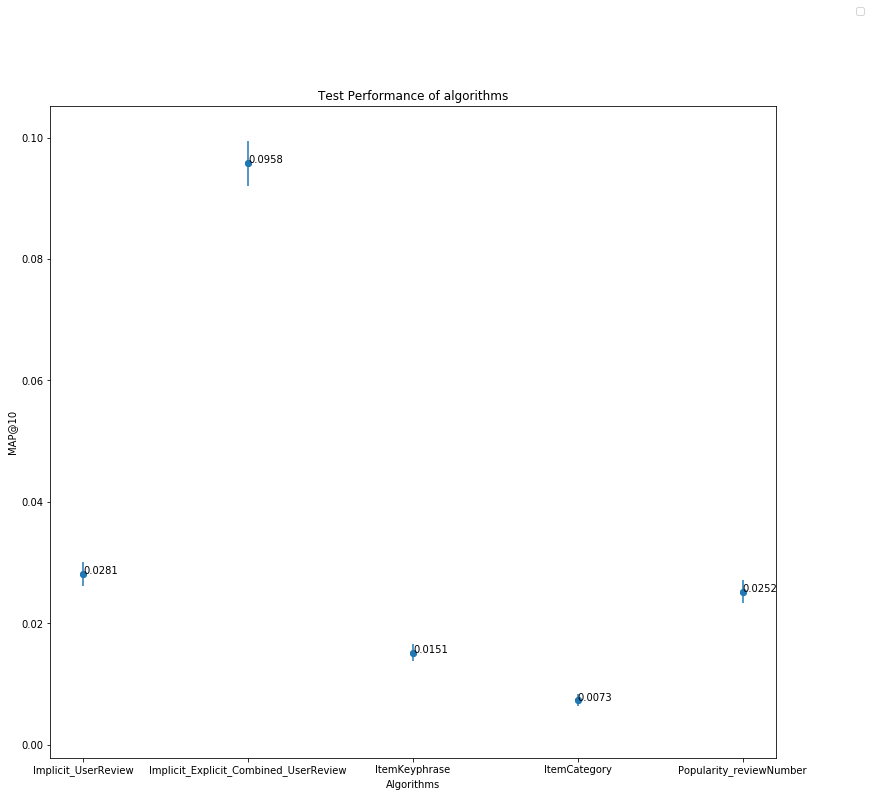

In [154]:
import matplotlib.pyplot as plt
listPrediction = testPerformance.items()

x1, y1 = zip(*listPrediction) # unpack a list of pairs into two tuples

x = []
y = []
err = []
for item in x1:
    x.append(item)
    
for item in y1:
    y.append(item[0])
    err.append(item[1])
    
plt.figure(figsize=(13,12))

plt.scatter(x,y)

plt.errorbar(x,y,yerr=err, linestyle="None", fmt='o')

for x2, y2 in zip(x, y): 
    plt.text(x2, y2, str(y2))
      
plt.title('Test Performance of algorithms')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.xlabel('Algorithms')
plt.ylabel('MAP@10')
plt.show()

## User-based KNN - explicitUI as prediction matrix Cross Validation

In [52]:
kRange = range(50,150,10)
ExplicitUI_basedCrossDict = {}

#Explicit UI 
mapList1 = individualKNNPrediction(rtrain_similarity, rtrain, kRange, rvalid)
ExplicitUI_basedCrossDict['explicitUI'] = mapList1

#Implicit UI
mapList2 = individualKNNPrediction(rtrain_implicit_similarity, rtrain, kRange, rvalid)
ExplicitUI_basedCrossDict['implicitUI'] = mapList2

#Scaled explicit UI
mapList3 = individualKNNPrediction(rtrain_WuserAvg_similarity, rtrain, kRange, rvalid)
ExplicitUI_basedCrossDict['scaledExplicitUI'] = mapList3

#UserVisit UI
mapList4 = individualKNNPrediction(rtrain_userVisit_similarity, rtrain, kRange, rvalid)
ExplicitUI_basedCrossDict['userVisitUI'] = mapList4

#UC_explicit - Explicit UI
mapList5 = individualKNNPrediction(uc_explicit_similarity, rtrain, kRange, rvalid)
ExplicitUI_basedCrossDict['ucExplicit_ExplicitUI'] = mapList5

#UC_implicit- Explicit UI
mapList6 = individualKNNPrediction(uc_implicit_similarity, rtrain, kRange, rvalid)
ExplicitUI_basedCrossDict['ucImplicit_ExplicitUI'] = mapList6

100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8909.53it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8753.12it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8836.09it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8887.76it/s]


In [75]:
#Save the performance dictionary 
saveDictToJson(ExplicitUI_basedCrossDict, 'ExplicitUI_basedCrossDict', trainOrTest='train')

In [76]:
ExplicitUI_basedCrossDict

{'explicitUI': {50: (0.07, 0.0032),
  60: (0.0712, 0.0032),
  70: (0.072, 0.0032),
  80: (0.0725, 0.0032),
  90: (0.073, 0.0032),
  100: (0.0731, 0.0032),
  110: (0.0732, 0.0032),
  120: (0.073, 0.0032),
  130: (0.0732, 0.0032),
  140: (0.0729, 0.0032)},
 'implicitUI': {50: (0.0176, 0.0015),
  60: (0.0183, 0.0015),
  70: (0.0189, 0.0015),
  80: (0.0197, 0.0016),
  90: (0.0201, 0.0016),
  100: (0.0203, 0.0016),
  110: (0.0207, 0.0016),
  120: (0.0212, 0.0016),
  130: (0.0216, 0.0016),
  140: (0.022, 0.0016)},
 'scaledExplicitUI': {50: (0.0417, 0.0025),
  60: (0.044, 0.0025),
  70: (0.0458, 0.0026),
  80: (0.0472, 0.0026),
  90: (0.0484, 0.0027),
  100: (0.0491, 0.0027),
  110: (0.05, 0.0027),
  120: (0.0506, 0.0027),
  130: (0.0511, 0.0027),
  140: (0.0519, 0.0028)},
 'userVisitUI': {50: (0.057, 0.0028),
  60: (0.0586, 0.0028),
  70: (0.0588, 0.0028),
  80: (0.0595, 0.0028),
  90: (0.0597, 0.0028),
  100: (0.0601, 0.0028),
  110: (0.0602, 0.0028),
  120: (0.0605, 0.0028),
  130: (0.0601

## User-based KNN - implicitUI as prediction matrix Cross Validation

In [55]:
kRange = range(50,150,10)
implicitUIbased_CrossDict = {}

#Explicit UI 
mapList1 = individualKNNPrediction(rtrain_similarity, rtrain_implicit, kRange, rvalid_implicit)
implicitUIbased_CrossDict['explicitUI'] = mapList1

#Implicit UI
mapList2 = individualKNNPrediction(rtrain_implicit_similarity, rtrain_implicit, kRange, rvalid_implicit)
implicitUIbased_CrossDict['implicitUI'] = mapList2

#Scaled explicit UI
mapList3 = individualKNNPrediction(rtrain_WuserAvg_similarity, rtrain_implicit, kRange, rvalid_implicit)
implicitUIbased_CrossDict['scaledExplicitUI'] = mapList3

#UserVisit UI
mapList4 = individualKNNPrediction(rtrain_userVisit_similarity, rtrain_implicit, kRange, rvalid_implicit)
implicitUIbased_CrossDict['userVisitUI'] = mapList4

#UC_explicit - Explicit UI
mapList5 = individualKNNPrediction(uc_explicit_similarity, rtrain_implicit, kRange, rvalid_implicit)
implicitUIbased_CrossDict['ucExplicit_ExplicitUI'] = mapList5

#UC_implicit- Explicit UI
mapList6 = individualKNNPrediction(uc_implicit_similarity, rtrain_implicit, kRange, rvalid_implicit)
implicitUIbased_CrossDict['ucImplicit_ExplicitUI'] = mapList6

100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9147.16it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9190.49it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9161.03it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9238.20it/s]


In [77]:
#Save the performance dictionary 
saveDictToJson(implicitUIbased_CrossDict, 'implicitUIbased_CrossDict', trainOrTest='train')

In [57]:
implicitUIbased_CrossDict

{'explicitUI': {50: (0.07, 0.0032),
  60: (0.0712, 0.0032),
  70: (0.072, 0.0032),
  80: (0.0725, 0.0032),
  90: (0.073, 0.0032),
  100: (0.0731, 0.0032),
  110: (0.0732, 0.0032),
  120: (0.073, 0.0032),
  130: (0.0732, 0.0032),
  140: (0.0729, 0.0032)},
 'implicitUI': {50: (0.0176, 0.0015),
  60: (0.0183, 0.0015),
  70: (0.0189, 0.0015),
  80: (0.0197, 0.0016),
  90: (0.0201, 0.0016),
  100: (0.0203, 0.0016),
  110: (0.0207, 0.0016),
  120: (0.0212, 0.0016),
  130: (0.0216, 0.0016),
  140: (0.022, 0.0016)},
 'scaledExplicitUI': {50: (0.0417, 0.0025),
  60: (0.044, 0.0025),
  70: (0.0458, 0.0026),
  80: (0.0472, 0.0026),
  90: (0.0484, 0.0027),
  100: (0.0491, 0.0027),
  110: (0.05, 0.0027),
  120: (0.0506, 0.0027),
  130: (0.0511, 0.0027),
  140: (0.0519, 0.0028)},
 'userVisitUI': {50: (0.057, 0.0028),
  60: (0.0586, 0.0028),
  70: (0.0588, 0.0028),
  80: (0.0595, 0.0028),
  90: (0.0597, 0.0028),
  100: (0.0601, 0.0028),
  110: (0.0602, 0.0028),
  120: (0.0605, 0.0028),
  130: (0.0601

In [67]:
saveDictToJson(ExplicitUI_basedCrossDict, 'ExplicitUI_basedCrossDict', trainOrTest='train')

In [71]:
testDict = loadDict('ExplicitUI_basedCrossDict', trainOrTest='train')

In [72]:
testDict

{'explicitUI': {'50': [0.07, 0.0032],
  '60': [0.0712, 0.0032],
  '70': [0.072, 0.0032],
  '80': [0.0725, 0.0032],
  '90': [0.073, 0.0032],
  '100': [0.0731, 0.0032],
  '110': [0.0732, 0.0032],
  '120': [0.073, 0.0032],
  '130': [0.0732, 0.0032],
  '140': [0.0729, 0.0032]},
 'implicitUI': {'50': [0.0176, 0.0015],
  '60': [0.0183, 0.0015],
  '70': [0.0189, 0.0015],
  '80': [0.0197, 0.0016],
  '90': [0.0201, 0.0016],
  '100': [0.0203, 0.0016],
  '110': [0.0207, 0.0016],
  '120': [0.0212, 0.0016],
  '130': [0.0216, 0.0016],
  '140': [0.022, 0.0016]},
 'scaledExplicitUI': {'50': [0.0417, 0.0025],
  '60': [0.044, 0.0025],
  '70': [0.0458, 0.0026],
  '80': [0.0472, 0.0026],
  '90': [0.0484, 0.0027],
  '100': [0.0491, 0.0027],
  '110': [0.05, 0.0027],
  '120': [0.0506, 0.0027],
  '130': [0.0511, 0.0027],
  '140': [0.0519, 0.0028]},
 'userVisitUI': {'50': [0.057, 0.0028],
  '60': [0.0586, 0.0028],
  '70': [0.0588, 0.0028],
  '80': [0.0595, 0.0028],
  '90': [0.0597, 0.0028],
  '100': [0.0601, 0

## Item based individual -Cross Validation

In [78]:
#IK TF-IDF
IK_MATRIX = X_cleaned_sparse
IK_similarity = train(IK_MATRIX)
IC_similarity = train(I_C_matrix)
IU_MATRIX = rtrain.T
IU_similarity = train(IU_MATRIX)
IU_MATRIX_IMPLICIT = rtrain_implicit.T
IU_similarity_implicit = train(IU_MATRIX_IMPLICIT)

### Using explicit UI as prediction matrix

In [83]:
kRange = range(50,150,10)
Itembased_CrossDict_explicitPredict = {}

#IK TF-IDF
mapList1 = individualKNNPrediction(IK_similarity, rtrain, kRange, rvalid, itemBased=True)
Itembased_CrossDict_explicitPredict['ItemBased_IK_ExplicitUI'] = mapList1

#ic
mapList2 = individualKNNPrediction(IC_similarity, rtrain, kRange, rvalid, itemBased=True)
Itembased_CrossDict_explicitPredict['ItemBased_IC_ExplicitUI'] = mapList2

#IU explicit
mapList3 = individualKNNPrediction(IU_similarity, rtrain, kRange, rvalid, itemBased=True)
Itembased_CrossDict_explicitPredict['ItemBased_IUExplicit_ExplicitUI'] = mapList3

#IU implicit
mapList4 = individualKNNPrediction(IU_similarity_implicit, rtrain, kRange, rvalid, itemBased=True)
Itembased_CrossDict_explicitPredict['ItemBased_IUImplicit_ExplicitUI'] = mapList4

100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8973.24it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9030.52it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8981.64it/s]


In [90]:
Itembased_CrossDict_explicitPredict

{'ItemBased_IK_ExplicitUI': {50: (0.0134, 0.0013),
  60: (0.0139, 0.0013),
  70: (0.0134, 0.0013),
  80: (0.0138, 0.0013),
  90: (0.0137, 0.0013),
  100: (0.0139, 0.0013),
  110: (0.0139, 0.0013),
  120: (0.0138, 0.0013),
  130: (0.0136, 0.0013),
  140: (0.0137, 0.0013)},
 'ItemBased_IC_ExplicitUI': {50: (0.0049, 0.0007),
  60: (0.0053, 0.0008),
  70: (0.0049, 0.0007),
  80: (0.005, 0.0008),
  90: (0.005, 0.0007),
  100: (0.005, 0.0008),
  110: (0.005, 0.0008),
  120: (0.0054, 0.0008),
  130: (0.0053, 0.0008),
  140: (0.0049, 0.0008)},
 'ItemBased_IUExplicit_ExplicitUI': {50: (0.019, 0.0016),
  60: (0.0195, 0.0016),
  70: (0.0199, 0.0016),
  80: (0.0199, 0.0016),
  90: (0.0202, 0.0016),
  100: (0.0208, 0.0017),
  110: (0.0214, 0.0017),
  120: (0.0216, 0.0017),
  130: (0.0216, 0.0017),
  140: (0.0216, 0.0017)},
 'ItemBased_IUImplicit_ExplicitUI': {50: (0.0476, 0.0029),
  60: (0.0509, 0.0031),
  70: (0.0529, 0.0031),
  80: (0.0552, 0.0032),
  90: (0.0566, 0.0033),
  100: (0.0584, 0.0033)

In [84]:
saveDictToJson(Itembased_CrossDict_explicitPredict, 'Itembased_CrossDict_explicitPredict', trainOrTest='train')

### Using implicit UI as prediction matrix

In [85]:
kRange = range(50,150,10)
Itembased_CrossDict_implicitPredict = {}

#IK TF-IDF
mapList1 = individualKNNPrediction(IK_similarity, rtrain_implicit, kRange, rvalid_implicit, itemBased=True)
Itembased_CrossDict_implicitPredict['ItemBased_IK_ImplicitUI'] = mapList1

#ic
mapList2 = individualKNNPrediction(IC_similarity, rtrain_implicit, kRange, rvalid_implicit, itemBased=True)
Itembased_CrossDict_implicitPredict['ItemBased_IC_ImplicitUI'] = mapList2

#IU explicit
mapList3 = individualKNNPrediction(IU_similarity, rtrain_implicit, kRange, rvalid_implicit, itemBased=True)
Itembased_CrossDict_implicitPredict['ItemBased_IUExplicit_ImplicitUI'] = mapList3

#IU implicit
mapList4 = individualKNNPrediction(IU_similarity_implicit, rtrain_implicit, kRange, rvalid_implicit, itemBased=True)
Itembased_CrossDict_implicitPredict['ItemBased_IUImplicit_ImplicitUI'] = mapList4

100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9210.49it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9114.40it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9150.66it/s]


In [89]:
Itembased_CrossDict_implicitPredict

{'ItemBased_IK_ImplicitUI': {50: (0.0091, 0.0011),
  60: (0.009, 0.001),
  70: (0.0087, 0.001),
  80: (0.0086, 0.001),
  90: (0.0084, 0.001),
  100: (0.0087, 0.001),
  110: (0.0085, 0.001),
  120: (0.0085, 0.001),
  130: (0.0084, 0.001),
  140: (0.0087, 0.001)},
 'ItemBased_IC_ImplicitUI': {50: (0.0029, 0.0006),
  60: (0.0034, 0.0006),
  70: (0.0034, 0.0006),
  80: (0.0033, 0.0006),
  90: (0.0036, 0.0006),
  100: (0.003, 0.0006),
  110: (0.0034, 0.0006),
  120: (0.003, 0.0006),
  130: (0.0033, 0.0006),
  140: (0.0029, 0.0006)},
 'ItemBased_IUExplicit_ImplicitUI': {50: (0.0364, 0.0024),
  60: (0.0379, 0.0025),
  70: (0.0392, 0.0025),
  80: (0.0405, 0.0025),
  90: (0.042, 0.0026),
  100: (0.0436, 0.0027),
  110: (0.0446, 0.0027),
  120: (0.0455, 0.0027),
  130: (0.046, 0.0027),
  140: (0.0464, 0.0027)},
 'ItemBased_IUImplicit_ImplicitUI': {50: (0.0076, 0.0009),
  60: (0.0077, 0.001),
  70: (0.0081, 0.001),
  80: (0.0079, 0.001),
  90: (0.0079, 0.001),
  100: (0.0082, 0.001),
  110: (0.00

In [86]:
saveDictToJson(Itembased_CrossDict_implicitPredict, 'Itembased_CrossDict_implicitPredict', trainOrTest='train')

## Combination Max cross validation 

In [70]:
#Pass in k range, return a dictionary for MAP@10
def individualKNNPredictionMaxMinAvg (similarityOne, similarityTwo, similarityThree, similarityFour, predictionMatrix, kRange, validOrTestMatrix, method):
    "Declaration for kRange = range(50,120,10)"
    #similarity = train(similarityMatrix)
    MAP10 = {}
    for kValue in kRange:
        user_item_prediction_score = predictUU(predictionMatrix, kValue,method, similarityOne, 
                                               similarityTwo, similarityThree, similarityFour)
        user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
        user_item_res = evaluate(user_item_predict, validOrTestMatrix) 
        MAP10[kValue] = user_item_res.get('MAP@10')[0]
        
    return MAP10

In [98]:
#Pass in k range, return a dictionary for MAP@10
def KNNPredictionMaxMinAvg (similarityOne, similarityTwo, similarityThree, similarityFour, predictionMatrix, validOrTestMatrix, method):
    user_item_prediction_score = predictUU(predictionMatrix, kValue,method, similarityOne, 
                                           similarityTwo, similarityThree, similarityFour)
    user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
    user_item_res = evaluate(user_item_predict, validOrTestMatrix) 

        
    return user_item_res.get('MAP@10')[0]

In [71]:
#Get a UI matrix if it's not item_similarity based or else IU
def predictUU(matrix_train, k, chooseWeigthMethod, similarity1=None, similarity2=None, similarity3=None, similarity4=None, similarity5=None, item_similarity_en = False):
    prediction_scores = []
    #Convert from list to ndarray, add an axis
    if isinstance(chooseWeigthMethod, list):
        chooseWeigthMethod = np.array(chooseWeigthMethod)[:, np.newaxis]
   
    "make sure that when passing in chooseWeightMethod, the weight must be aligned with similarity metrices, even if set to None"
    "They should add to 1 as well"
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
    #for user_index in tqdm(range(10,20)):
        
        numberSimilarMatrix = 0
        # Get user u's prediction scores for all items 
        #Get prediction/similarity score for each user 1*num or user or num of items
        if similarity1 is not None:
            vector_u1 = similarity1[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u1 = [0]*matrix_train.shape[0]
            
        if similarity2 is not None:
            vector_u2 = similarity2[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u2 = [0]*len(vector_u1)
            
        if similarity3 is not None:
            vector_u3 = similarity3[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u3 = [0]*len(vector_u1)
            
        if similarity4 is not None:
            vector_u4 = similarity4[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u4 = [0]*len(vector_u1)
        
        if similarity5 is not None:
            vector_u5 = similarity5[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u5 = [0]*len(vector_u1)
        
        #Temperary vector that stacks all 4 vectors together
        tempVector = np.array([vector_u1,vector_u2,vector_u3,vector_u4, vector_u5])
        
        if chooseWeigthMethod is None:
            #Get the similarity score from the first similarity matrix anyways 
            vector_u = vector_u1.copy()
            
        #If we are choosing the max, min, avg or similarity scores
        if chooseWeigthMethod is not None:
            if chooseWeigthMethod == 'max':
                vector_u = tempVector.max(axis=0)
            elif chooseWeigthMethod == 'min':
                vector_u = tempVector.min(axis=0)
            elif chooseWeigthMethod == 'average':
                vector_u = tempVector.mean(axis=0)
            elif isinstance(chooseWeigthMethod, np.ndarray):
                print(chooseWeigthMethod)
                #Validate that number of weights passed in equals number of matrices
                #assert(len(chooseWeigthMethod) == numberSimilarMatrix)
                #Get the new combined similarity vector 
                weighted_u = tempVector * chooseWeigthMethod
                vector_u =np.sum(weighted_u, axis=0)
                #print((vector_u == vector_u4).sum())
                
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        #similar_users_weights = similarity1[user_index][similar_users]
        similar_users_weights = vector_u[similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res
    #return vector_u

In [62]:
rtrain.shape[1]

3998

In [54]:
combinationDict = {
    'comb1': [1, 2, 3, 4],
    'comb2': [1, 2, 3],
    'comb3': [1, 2, 4],
    'comb4': [2, 3, 4],
    'comb5': [1, 3, 4],
    'comb6': [1, 2],
    'comb7': [1, 3],
    'comb8': [1, 4],
    'comb9': [2, 3],
    'comb10': [2, 4],
    'combe11':[3,4]
    }

 #UU similarity, using cosine similarity
similarity1 = rtrain_similarity
similarity2 = rtrain_WuserAvg_similarity
similarity3 = rtrain_userVisit_similarity
similarity4 = rtrain_implicit_similarity


predictionMatrixDict = {'prediction1':rtrain, 
                        'prediction2': rtrain_userAvg, 
                        'prediction3:': userVisitMatrix, 
                        'prediction4': rtrain_implicit}

#Indicates whether to use similarity matrix i, or it's a none 
SimilarityMatrixIndex = {1: [similarity1, None],
                         2: [similarity2, None],
                         3: [similarity3, None],
                         4: [similarity4, None]} 

In [81]:
#loop through the combination and make prediction using each prediction matricies
#Pass in the k ranges to loop and see performance 
def computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, rvalid, rvalid_userAvg, rvalid_implicit, combinationDict, SimilarityMatrixIndex, kTune, method = 'max'):

    predictionComb = {}

    #loop through the combination dictionary
    for combination, indexList in combinationDict.items():
        #Loop through the similarity matrices to get similarity matricies 1-5
        #see if we enable similarity matrix i for i = 1-5
        for index in SimilarityMatrixIndex.keys():
            if index in indexList:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
                    
            else:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][1]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][1]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][1]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][1]

       
        #using prediction matrix 1 -  rtrain, return back a dictionary that k values are the keys 
#         predictionComb['UI_Explicit_matrix:'+combination] = individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
#                                                                     similarityThree, similarityFour, 
#                                                                     rtrain, kTune, rvalid, method)
        
#         predictionComb['UI_wUserAvg_matrix:'+combination] = individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
#                                                                     similarityThree, similarityFour, 
#                                                                     rtrain_userAvg, kTune, rvalid, method)
   
#         predictionComb['UI_userVisit_matrix'+combination] = individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
#                                                                     similarityThree, similarityFour, 
#                                                                     userVisitMatrix, kTune, rvalid, method)

        predictionComb['UI_Implicit_matrix'+combination] =  individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
                                                                    similarityThree, similarityFour, 
                                                                    rtrain_implicit, kTune, rvalid_implicit, method)
        
    #plotingCombination(prediction1, prediction2, prediction3, prediction4, kTune, method)
    return predictionComb

In [82]:
# run this!!!!!!!!!!
kRange = range(50,150,10)
PredictionComValid = computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, rvalid, rvalid_userAvg, rvalid_implicit, combinationDict, SimilarityMatrixIndex, kRange)

100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9267.39it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 8934.93it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9380.84it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9438.79it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9526.56it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9291.33it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6100/6100 [00:00<00:00, 9443.89it/s]


In [83]:
saveDictToJson(PredictionComValid, 'PredictionComValid_implicitPrediction', trainOrTest='train')

In [84]:
PredictionComValid

{'UI_Implicit_matrixcomb1': {50: 0.048,
  60: 0.0502,
  70: 0.0522,
  80: 0.0533,
  90: 0.0548,
  100: 0.0559,
  110: 0.0565,
  120: 0.0576,
  130: 0.0584,
  140: 0.0587},
 'UI_Implicit_matrixcomb2': {50: 0.0574,
  60: 0.0591,
  70: 0.0611,
  80: 0.0626,
  90: 0.063,
  100: 0.0635,
  110: 0.0639,
  120: 0.0642,
  130: 0.0644,
  140: 0.0642},
 'UI_Implicit_matrixcomb3': {50: 0.0496,
  60: 0.0519,
  70: 0.0538,
  80: 0.0556,
  90: 0.0571,
  100: 0.0582,
  110: 0.0592,
  120: 0.0599,
  130: 0.0608,
  140: 0.0612},
 'UI_Implicit_matrixcomb4': {50: 0.04,
  60: 0.042,
  70: 0.044,
  80: 0.0448,
  90: 0.0462,
  100: 0.0476,
  110: 0.0482,
  120: 0.0493,
  130: 0.05,
  140: 0.0508},
 'UI_Implicit_matrixcomb5': {50: 0.0529,
  60: 0.0546,
  70: 0.0559,
  80: 0.0571,
  90: 0.0578,
  100: 0.0586,
  110: 0.0593,
  120: 0.0597,
  130: 0.0598,
  140: 0.06},
 'UI_Implicit_matrixcomb6': {50: 0.0599,
  60: 0.0627,
  70: 0.0649,
  80: 0.0664,
  90: 0.0668,
  100: 0.0679,
  110: 0.0678,
  120: 0.0686,
  1

## Weight combinations

## Item Base KNN using TF-IDF

In [ ]:
IK_MATRIX = X_cleaned_sparse

In [ ]:
I_I_similarity = train(IK_MATRIX)
item_based_prediction_score4 = predict(rtrain, 10, I_I_similarity, item_similarity_en= True)
#for each restuarant top50 users 
item_based_predict4 = prediction(item_based_prediction_score4, 50, rtrain)

In [ ]:
item_based_res_TFIDF = evaluate(item_based_predict4, rvalid)

In [ ]:
item_based_res_TFIDF

## Item based KNN with IC Matrix

In [ ]:
I_C_matrix.shape

In [ ]:
similarity_I_C = train(I_C_matrix)

In [ ]:
user_item_prediction_score_I_C = predict(e
                                         , 90, similarity_I_C, item_similarity_en= True)


In [ ]:
#for each restuarant top50 users 
item_based_predict_I_C = prediction(user_item_prediction_score_I_C, 50, rtrain)

In [ ]:
item_based_res_I_C = evaluate(item_based_predict_I_C, rvalid)

In [ ]:
item_based_res_I_C

## User based KNN with explicit UC Matrix

In [ ]:
I_C_matrix.shape

In [ ]:
rtrain_implicit.shape

In [ ]:
U_C_matrix = rtrain_implicit*I_C_matrix

In [ ]:
similarity_UC = train(U_C_matrix)
user_item_prediction_score_UC = predict(rtrain, 90, similarity_UC, item_similarity_en= False)
user_item_predict_UC = prediction(user_item_prediction_score_UC, 90,rtrain)
user_item_res_UC = evaluate(user_item_predict_UC, rvalid)
user_item_res_UC

In [ ]:
user_item_res_UC

## User based KNN with implicit UC Matrix

In [ ]:
U_C_matrix

In [ ]:
def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

In [ ]:
U_C_matrix_implicit = getImplicitMatrix(U_C_matrix,3)

In [ ]:
U_C_matrix_implicit

In [ ]:
similarity_UC_implicit = train(U_C_matrix_implicit)
user_item_prediction_score_UC_implicit = predict(rtrain, 90, similarity_UC_implicit, item_similarity_en= False)
user_item_predict_UC_implicit = prediction(user_item_prediction_score_UC_implicit, 90,rtrain)
user_item_res_UC_implicit = evaluate(user_item_predict_UC_implicit, rvalid)

In [ ]:
user_item_res_UC_implicit

## Try combining different similarity scores

In [99]:
#Get a UI matrix if it's not item_similarity based or else IU
def predictUU(matrix_train, k, similarity1, similarity2=None, similarity3=None, similarity4=None, weight1=None, weight2=None, weight3=None, weight4=None, chooseWeigthMethod = None, item_similarity_en = False):
    prediction_scores = []
    
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
        
        numberSimilarMatrix = 0
        # Get user u's prediction scores for all items 
        #Get prediction/similarity score for each user 1*num or user or num of items
        vector_u1 = similarity1[user_index]
        numberSimilarMatrix += 1
        
        if similarity2 is not None:
            vector_u2 = similarity2[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u2 = [0]*len(vector_u1)
            
        if similarity3 is not None:
            vector_u3 = similarity3[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u3 = [0]*len(vector_u1)
            
        if similarity4 is not None:
            vector_u4 = similarity4[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u4 = [0]*len(vector_u1)
        
        vector_u = vector_u1.copy()
            
        #If we are choosing the max, min, or avg or similarity scores
        if chooseWeigthMethod is not None:
            #loop through the user index 
            for item_index in tqdm(range(matrix_train.shape[0])):

                if chooseWeigthMethod == 'max':
                    vector_u[item_index] = max(vector_u1[item_index], vector_u2[item_index], vector_u3[item_index],vector_u4[item_index])
                elif chooseWeigthMethod == 'min':
                    vector_u[item_index] = min(vector_u1[item_index], vector_u2[item_index], vector_u3[item_index],vector_u4[item_index])
                elif chooseWeigthMethod == 'average':
                    vector_u[item_index] = (vector_u1[item_index]+vector_u2[item_index]+vector_u3[item_index]+vector_u4[item_index])/(numberSimilarMatrix)
        
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        #similar_users_weights = similarity1[user_index][similar_users]
        similar_users_weights = vector_u[similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res
    #return vector_u

In [ ]:
#UU similarity, using cosine similarity
similarity1 = train(rtrain)
#similarity2 = train(rtrain_userAvg)
similarity2 = None
#similarity3 =train(userVisitMatrix)
similarity3 = None
similarity4 = train(rtrain_implicit)
#similarity4 = None
weight1 = None
weight2=None
weight3=None
#vectorU = predictUU(rtrain_userAvg, 90, similarity1, similarity2, similarity3, weight1, weight2, weight3, item_similarity_en= False)
user_item_prediction_score1 = predictUU(rtrain, 90, similarity1, similarity2, similarity3, similarity4, weight1, weight2, weight3, chooseWeigthMethod = 'max', item_similarity_en= False)
user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
user_item_res1 = evaluate(user_item_predict1, rvalid)

In [ ]:
for number in rtrain_userAvg:
    print(number)

In [ ]:
rtrain_userAvg[0][0].toarray()

In [ ]:
rtrain_userAvg.shape

In [ ]:
def getImplicitMatrix(sparseMatrix, threashold=0):
    temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
    temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
    return temp_matrix

In [ ]:
userVisitMatrix = getImplicitMatrix(rtrain)

In [ ]:
#UU similarity
similarity3 = train(userVisitMatrix)
#get a user-item matrix  UI prediction
#Predict using UI matrix with ratings in it 
user_item_prediction_score3 = predict(userVisitMatrix, 90, similarity3, item_similarity_en= False)
user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
#Check user item prediction score
user_item_res3 = evaluate(user_item_predict3, rvalid)